# Regressão Logística em Python

Dependências

In [0]:
%matplotlib inline
import time

from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', palette='pastel')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def bigprint(*args):
    display(HTML('<h3>' + ' '.join(str(arg) for arg in args) + '</h3>'))

## Dados

**Dados sintéticos**

- 2 classes: $y = 0$ ou $y = 1$
- Overlap pequeno entre classes

**Número de samples**

$M = 30$

**Número de features (variáveis independentes)**

$n = 1$

In [18]:
from sklearn.datasets import make_classification

M = 30
n = 1

# geração dos dados sintéticos
X, y = make_classification(n_samples=M, n_features=1, n_informative=1,
                           n_redundant=0, n_classes=2, n_clusters_per_class=1,
                           class_sep=1.2, flip_y=0.01, random_state=0, shuffle=True)

data_frame = pd.DataFrame(np.c_[X, y], columns=['x', 'y'])
display(data_frame.head())
display(data_frame.tail())

ax = plt.gca()
ax.scatter(X[y == 1], y[y == 1], s=100, marker='x', label='positivo')
ax.scatter(X[y == 0], y[y == 0], s=100, marker='x', label='negativo')

def _adjust_plot():
    plt.legend()
    plt.axis([-3, 3, -0.1, 1.1])
    plt.locator_params(axis='x', nbins=6)
_adjust_plot()

x    y
0 -2.067330  0.0
1  0.271629  1.0
2 -1.291606  0.0
3 -0.356800  0.0
4  0.930119  1.0

x    y
25 -1.092014  0.0
26 -1.072162  0.0
27 -0.331374  0.0
28  0.788784  0.0
29  1.734319  1.0

## numpy: Regressão Logística com SGD

**Função logística (ou sigmoid)**
<br><br>
$\sigma(t) = \frac{1}{1 + e^{-t}}$
<br><br>
**Modelo**
<br><br>
Predição a partir de um vetor de features $\mathbf{x}$:

$\hat{p} = h(\mathbf{x}; \theta) = \sigma(\theta_0 + \theta_1 x_1 + \ldots + \theta_n x_n) = \sigma(\theta^T \cdot \mathbf{x})$

$\hat{y} = \left\{\begin{matrix}
0 & \text{se } \hat{p} < 0.5,\\ 
1 & \text{se } \hat{p} \ge 0.5
\end{matrix}\right.$
<br><br>
**Fronteira de decisão**
<br><br>
$\theta^T \cdot \mathbf{x} \ge 0$,

pois $\sigma(0) = 0.5$.
<br><br>
Para $n = 1$:

$\theta_0 + \theta_1 x_1 \ge 0 \Rightarrow x_1 \ge - \theta_0 / \theta_1$
<br><br>
Para $n = 2$:

$\theta_0 + \theta_1 x_1 + \theta_2 x_2 \ge 0 \Rightarrow x_1 \ge - \frac{\theta_0}{\theta_1} - \frac{\theta_2} {\theta_1} x_2$
<br><br>
**Função de custo da classificação: Negative Log-Likelihood**
<br><br>
Custo para a predição de uma amostra:
<br>
$\begin{align*}c(\theta)
&= \left\{\begin{matrix}
-\log(\hat{p})  & \text{se } y = 1,\\ 
-\log(1 - \hat{p}) & \text{se } y = 0
\end{matrix}\right.\\
&= -y\log(\hat{p}) -(1 - y)\log(1 - \hat{p})
\end{align*}$
<br><br>
Custo para predição de um conjunto de amostras:

$J(\theta) = -\frac{1}{M}\sum_{i=1}^{M} \left[ y^{(i)} \cdot \log(\hat{p}^{(i)}) + \left(1 - y^{(i)}\right) \cdot \log(1 - \hat{p}^{(i)}) \right]$
<br><br>

### Derivada parcial da função de custo para $\theta_{j=1 \ldots n}$
<br>
$\frac{\partial}{\partial \theta_j} J(\theta) = \frac{1}{M} \sum_{i=1}^{M}\left(\underbrace{\sigma(\theta^T \cdot \mathbf{x})}_{\hat{p}^{(i)}} - y^{(i)}\right)x_j^{(i)}$
<br><br>

### Gradiente da função de custo
<br>
$\underset{n\times 1}{\nabla_\theta J(\theta)} = \frac{1}{M} \underset{n\times M}{\mathbf{X}^T} \cdot \left(\sigma \left( \underset{M\times n}{\mathbf{X}} \cdot \underset{n\times 1}{\theta} \right) - \underset{M\times 1}{\mathbf{y}} \right)$


#### Forma da curva Sigmoid

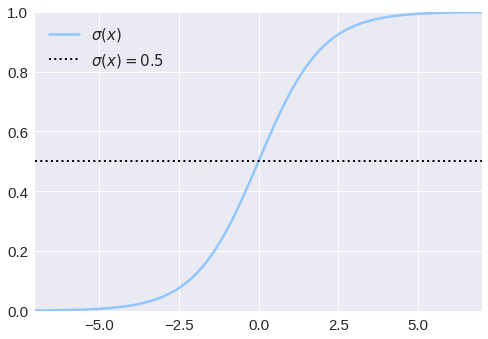

In [19]:
x_sigmoid = np.linspace(-7, 7, 100)

y_sigmoid = 1.0 / (1.0 + np.exp(-1.0 * x_sigmoid))

plt.plot(x_sigmoid, y_sigmoid, label='$\sigma(x)$')
plt.axis([-7, 7, 0.0, 1.0])
plt.locator_params(axis='x', nbins=6)
plt.axhline(y=0.5, c='k', ls='dotted', lw=2, label='$\sigma(x) = 0.5$')
plt.legend()

#### Forma da função de custo

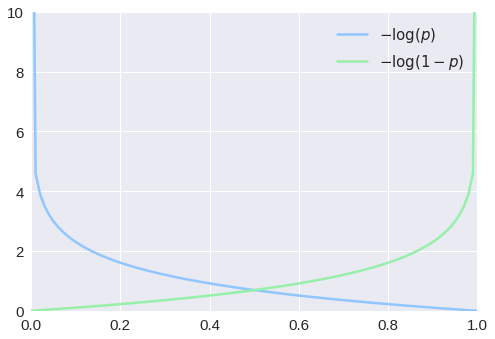

In [20]:
x_cost = np.linspace(0, 1, 100)

plt.plot(x_cost, -np.log(x_cost + 1e-10), label='$-\log(p)$')
plt.plot(x_cost, -np.log(1 - x_cost + 1e-10), label='$-\log(1 - p)$')

plt.axis([0, 1, 0, 10])
plt.locator_params(axis='x', nbins=6)
plt.legend()

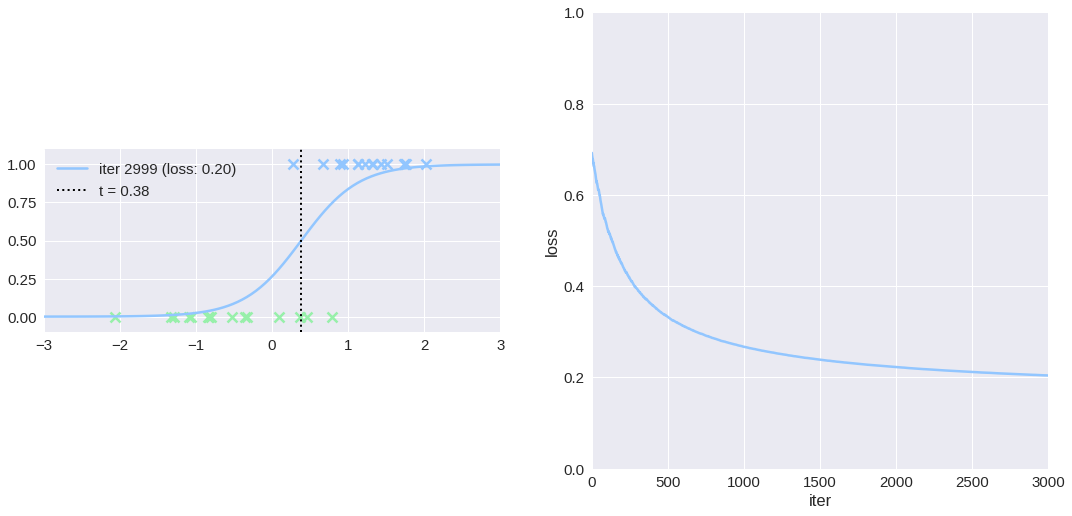

In [27]:
def h(theta, X):
    """Hipótese da regressão logística
    
    theta: nx1
    X: Mxn
    
    retorna: Mx1
    """
    return 1.0 / (1.0 + np.exp(-1.0 * X.dot(theta)))

### Hiperparâmetros
lr = 0.3  # learning rate ou tamanho do passo (eta)
max_epochs = 100  # máximo de épocas (passadas por todo o conjunto de dados)
max_iter = M * max_epochs  # máximo de iterações

### Adiciona bias
X_ = np.c_[np.ones((M, 1)), X]
y_ = y.reshape(-1, 1)

### Fixa semente para reproducibilidade
np.random.seed(0)

### Inicialização dos parâmetros
# theta = np.random.randn(n + 1, 1)
theta = np.zeros((n + 1, 1))
# print(theta.shape, X_.shape, (h(theta, X_) - y_).shape, y_.shape)

losses = []

X_new = np.linspace(-3, 3, 100).reshape(-1, 1)
X_new_ = np.c_[np.ones((100, 1)), X_new]

for i in range(max_iter):
    #### Reordena amostras a cada época nova
    if i % M == 0:
        idx_order = np.random.permutation(M)

    #### Escolhe amostra aleatória
    idx = idx_order[i % M]
    X_sample = X_[idx, :].reshape(1, -1)
    y_sample = y_[idx, :].reshape(1, -1)

    #### Cálculo do gradiente (d(MSE)/d(theta))
    grad = 1.0 / M * X_sample.T.dot(h(theta, X_sample) - y_sample)

    ### Atualização dos parâmetros
    theta = theta - lr * grad

    ### Monitoramento da função de custo (loss)
    y_proba = h(theta, X_)
    loss = -1.0 * (y_ * np.log(y_proba) + (1.0 - y_)*np.log(1.0 - y_proba)).mean()
    losses.append(loss)
    decision_boundary = -theta[0, 0] / theta[1, 0]

    if (i + 1) % (max_iter // 10) == 0:
        clear_output(wait=True)
        plt.figure(figsize=(18, 16))

        ### Plot da estimativa atual
        ax1 = plt.subplot(121, aspect=2)
        ax1.scatter(X[y == 1], y[y == 1], s=100, marker='x')
        ax1.scatter(X[y == 0], y[y == 0], s=100, marker='x')
        y_proba = h(theta, X_new_)
        ax1.plot(X_new, y_proba, '-', label='iter {} (loss: {:.2f})'.format(i, loss))
        plt.axvline(x=decision_boundary, c='k', ls='dotted', lw=2,
                    label='t = {:.2f}'.format(decision_boundary))
        _adjust_plot()

        ### Plot da loss
        ax2 = plt.subplot(122, aspect=max_iter)
        ax2.axis([0, max_iter, 0, 1])
        ax2.set_xlabel('iter')
        ax2.set_ylabel('loss')
        ax2.plot(np.arange(i + 1), losses)

        plt.show()
        display(plt.gcf())
        time.sleep(1.0)

bigprint('theta:', theta.flatten())

y_label = y == 1.0
y_pred = (h(theta, X_) > 0.5).flatten()
acc = (y_label == y_pred).mean()
bigprint('accuracy:', acc)

## scikit-learn (LogisticRegression, SGDClassifier)

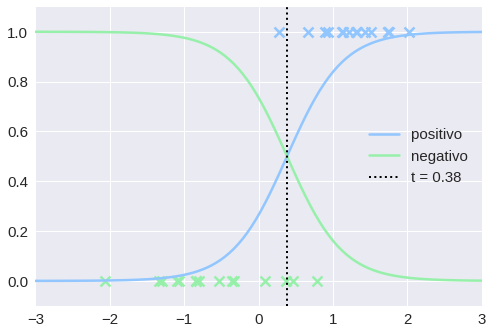

In [28]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score

# clf = LogisticRegression()
clf = SGDClassifier(loss='log', penalty='none', max_iter=100, eta0=0.01, learning_rate='constant', random_state=0)
clf.fit(X, y)

ax = plt.gca()
ax.scatter(X[y == 1], y[y == 1], s=100, marker='x')
ax.scatter(X[y == 0], y[y == 0], s=100, marker='x')

X_new = np.linspace(-3, 3, 100).reshape(-1, 1)
y_proba = clf.predict_proba(X_new)

decision_boundary = -clf.intercept_[0] / clf.coef_[0, 0]
bigprint('theta:', clf.intercept_, clf.coef_)

plt.plot(X_new, y_proba[:, 1], "-", label="positivo")
plt.plot(X_new, y_proba[:, 0], "-", label="negativo")
plt.axvline(x=decision_boundary, c='k', ls='dotted', lw=2,
            label='t = {:.2f}'.format(decision_boundary))
_adjust_plot()

acc = accuracy_score(y, clf.predict(X))
bigprint('accuracy:', acc)